# aQa Final Project: Qualitive comparison of Quantum Neural Networks and Classical Neural Networks

Firstly, import the correct libraries and set the random seed. This may take some time. <br>
Make sure the correct versions are installed (see requirements.txt).

In [46]:
import tensorflow as tf
import tensorflow_quantum as tfq


import cirq
import numpy as np
import seaborn as sns


from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, accuracy_score as acc

%matplotlib inline
import matplotlib.pyplot as plt
#np.random.seed(19)

Next, we will define the depth and the number of qubits. We can sweep these variables later. <br>
We can also generate the rotations that will generate the randomd data.

In [29]:
depth = 4
n_qubits = 3

randomRotations = np.random.uniform(-2*np.pi , 2 * np.pi, (depth * n_qubits))

## Quantum Neural network

In [30]:
def buildQuantumModel(encoding: np.array, parameters: np.array, depth : int, n_qubits : int) -> None:
    qubits = cirq.LineQubit.range(n_qubits)

    #encoding layer
    yield [cirq.rz(encoding[i])(qubits[i]) for i in range(n_qubits)]
    yield [cirq.ry(encoding[i])(qubits[i]) for i in range(n_qubits)]
    yield [cirq.rx(encoding[i])(qubits[i]) for i in range(n_qubits)]

    #variational layer
    for l in range(depth):
        for i in range(n_qubits):
            yield cirq.rx(parameters[i + l*n_qubits])(qubits[i])
            yield cirq.ry(parameters[i + l*n_qubits])(qubits[i])
        for i in range(n_qubits-1):
            yield cirq.CZ(qubits[i], qubits[i+1])



simulator = cirq.Simulator()

As the quantum neural network output needs to be simulated, we will use the statevector simulator. <br>

In [31]:
def runCircuit(data : np.array, parameters : np.array) -> float:


    quantumModel = cirq.Circuit(buildQuantumModel(data, parameters, depth, n_qubits))
    result = simulator.compute_amplitudes(quantumModel, bitstrings=[2**n_qubits-1])

    norm = np.linalg.norm(result)

    return norm

## Classical Neural network

In [32]:
def buildClassicalModel(depth : int , trainable : bool) -> tf.keras.Sequential:

    classicModel = tf.keras.Sequential()
    
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=10.0, seed=19)
    for l in range(depth):
        classicModel.add(tf.keras.layers.Dense(n_qubits, activation='relu', kernel_initializer=initializer, trainable=trainable))

    classicModel.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer, trainable=trainable))

    return classicModel

classicModel = buildClassicalModel(depth, True)
dataClassicalModel = buildClassicalModel(depth, False)

## Data generation

Generate some data within the range of 0 and 2 pi. <br>

In [33]:
def generateSamples(samples : int) -> np.array:

    empty = np.array([])

    for i in range(samples):
        empty = np.append(empty, np.random.uniform(0 , 2 * np.pi, 2))

    empty = empty.reshape(samples, 2)

    data = np.zeros((empty.shape[0], empty.shape[1] + 1))
    data[:,:2] = empty
    data[:,-1] = empty[:,0]*empty[:,1]

    return data

#print(generateSamples(10))

Feed into the untrained quantum neural network and the classical neural network. <br>

In [34]:
dataClassicalModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
data = generateSamples(1000)

classicLabels = dataClassicalModel.predict(data)
onelabel = zerolabel = 0

for i in range(len(classicLabels)):
    if classicLabels[i] > 0.5:
        classicLabels[i] = 1
        onelabel += 1
    else:
        classicLabels[i] = 0
        zerolabel += 1

print("1s: ", onelabel)
print("0s: ", zerolabel)

1s:  0
0s:  1000


<Axes: >

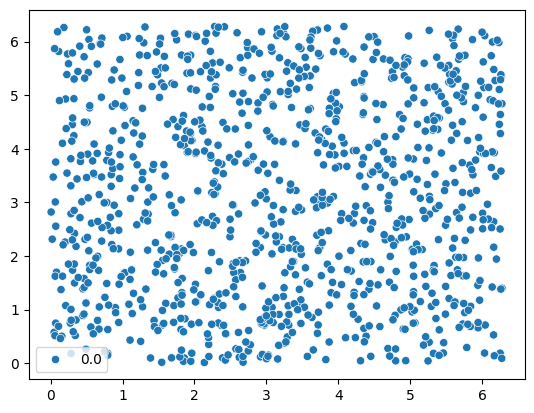

In [35]:
#plot the data points
fig, ax = plt.subplots()
sns.scatterplot(x=data[:,0], y=data[:,1], hue=classicLabels.flatten(), ax=ax)

In [36]:
quantumLabels = [runCircuit(data[i,:], randomRotations) for i in range(len(data))]

onelabel = zerolabel = 0

for i in range(len(quantumLabels)):
    if quantumLabels[i] > 0.5:
        quantumLabels[i] = 1
        onelabel += 1
    else:
        quantumLabels[i] = 0
        zerolabel += 1

print("1s: ", onelabel)
print("0s: ", zerolabel)

1s:  164
0s:  836


<Axes: >

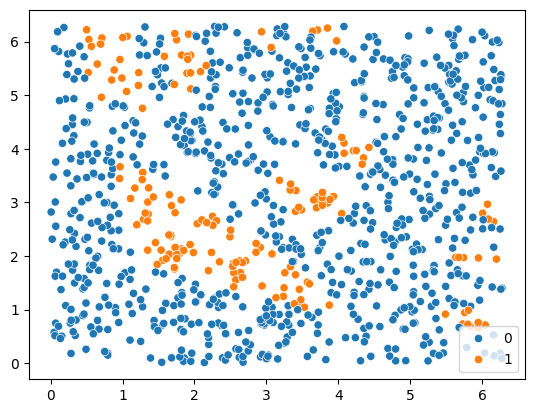

In [37]:
fig, ax = plt.subplots()
sns.scatterplot(x=data[:,0], y=data[:,1], hue=quantumLabels, ax=ax)

## Training

Firstly, train the classical neural network on the quantum neural network data. <br>


In [38]:
X_train, X_test, y_train, y_test = train_test_split(data, quantumLabels, test_size=0.33, random_state=4)

classicModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

y_train = np.array(y_train)
y_test = np.array(y_test)


classicModel.fit(X_train, y_train, epochs=10)

classicModel.evaluate(X_test, y_test)

Epoch 1/10
21/21 [==============================] - 1s 2ms/step - loss: 1122741.6250 - accuracy: 0.1776
Epoch 2/10
21/21 [==============================] - 0s 1ms/step - loss: 1096486.1250 - accuracy: 0.1776
Epoch 3/10
21/21 [==============================] - 0s 1ms/step - loss: 1070721.3750 - accuracy: 0.1776
Epoch 4/10
21/21 [==============================] - 0s 1ms/step - loss: 1045408.8750 - accuracy: 0.1776
Epoch 5/10
21/21 [==============================] - 0s 2ms/step - loss: 1020627.5000 - accuracy: 0.1776
Epoch 6/10
21/21 [==============================] - 0s 1ms/step - loss: 996636.3750 - accuracy: 0.1776
Epoch 7/10
21/21 [==============================] - 0s 3ms/step - loss: 972574.6875 - accuracy: 0.1776
Epoch 8/10
21/21 [==============================] - 0s 3ms/step - loss: 949054.1875 - accuracy: 0.1776
Epoch 9/10
21/21 [==============================] - 0s 2ms/step - loss: 926320.3125 - accuracy: 0.1776
Epoch 10/10
11/11 [==============================] - 0s 1ms/step - l

[1014927.0, 0.13636364042758942]

Then, train the quantum neural network on the quantum neural network data. <br>

In [44]:
def calculateLoss(parameters : np.array, data: np.array, labels: np.array) -> float:

    loss = 0

    probs = [runCircuit(data[i,:], parameters) for i in range(len(data))]

    for i in range(len(probs)):
        if probs[i] > 0.5:
            probs[i] = 1
        else:
            probs[i] = 0

    return mse(labels, probs)
    

cost = []


def optimize(parameters : np.array) -> float:

    singleCost = calculateLoss(parameters, X_train, y_train)
    cost.append(singleCost)

    return singleCost



result = minimize(optimize, randomRotations, method='COBYLA', options={"maxiter": 50})

In [42]:
print(result)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.0
       x: [ 4.098e-01 -4.234e+00  4.531e+00 -2.540e+00  2.458e+00
           -6.637e-01  9.166e-01  5.308e+00  2.776e+00  1.267e+00
           -2.955e-01 -3.570e-01]
    nfev: 10
   maxcv: 0.0


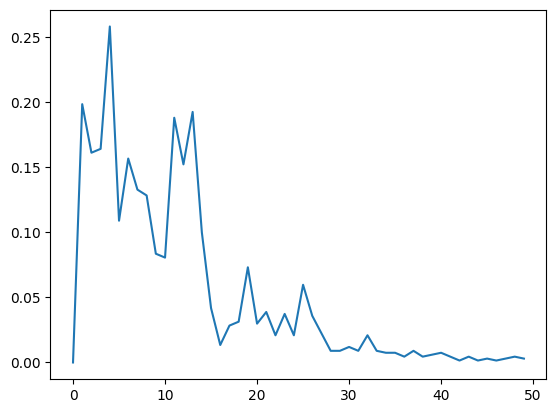

In [45]:
plt.plot(list(range(len(cost))), cost)
plt.show()